#  Setup

In [2]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay, f1_score, recall_score, precision_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from operator import itemgetter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 5.3 MB/s 
     |████████████████████████████████| 297 kB 11.7 MB/s 
     |████████████████████████████████| 856 kB 16.5 MB/s 


In [3]:
pybaseball.cache.enable()
data = statcast('2022-04-07', '2022-10-05')
#data = statcast('2022-04-07', '2022-05-05')

print(data.shape)
data.head(10)

This is a large query, it may take a moment to complete


100%|██████████| 29/29 [00:55<00:00,  1.92s/it]


(110153, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1209,FF,2022-05-05,94.0,-1.98,5.48,"Mayers, Mike",666915,594577,field_out,hit_into_play,...,8,8,0,0,8,Standard,Standard,224,0.0,-0.083
1229,FF,2022-05-05,94.3,-2.15,5.46,"Mayers, Mike",666915,594577,NaN,foul,...,8,8,0,0,8,Standard,Standard,220,0.0,-0.031
1281,FC,2022-05-05,88.5,-2.5,5.35,"Mayers, Mike",666915,594577,NaN,called_strike,...,8,8,0,0,8,Standard,Standard,173,0.0,-0.023
1301,SL,2022-05-05,85.7,-2.34,5.45,"Mayers, Mike",666915,594577,NaN,ball,...,8,8,0,0,8,Standard,Standard,90,0.0,0.023
1337,FF,2022-05-05,95.2,-1.9,5.48,"Mayers, Mike",666915,594577,NaN,ball,...,8,8,0,0,8,Standard,Standard,223,0.0,0.015
1369,FF,2022-05-05,95.1,-2.16,5.44,"Mayers, Mike",614173,594577,strikeout,swinging_strike,...,8,8,0,0,8,Infield shift,Standard,223,0.0,-0.207
1399,FF,2022-05-05,94.2,-2.25,5.45,"Mayers, Mike",614173,594577,NaN,ball,...,8,8,0,0,8,Infield shift,Standard,223,0.0,0.073
1442,SL,2022-05-05,85.0,-2.45,5.47,"Mayers, Mike",614173,594577,NaN,called_strike,...,8,8,0,0,8,Infield shift,Standard,79,0.0,-0.046
1464,FF,2022-05-05,94.0,-2.2,5.43,"Mayers, Mike",614173,594577,NaN,foul,...,8,8,0,0,8,Infield shift,Standard,226,0.0,-0.042
1492,FF,2022-05-05,93.8,-2.29,5.46,"Mayers, Mike",614173,594577,NaN,ball,...,8,8,0,0,8,Infield shift,Standard,226,0.0,0.044


# Data Cleaning

## Determining Training Data Columns

In [4]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitch_type', dtype('O'))
('game_date', dtype('<M8[ns]'))
('release_speed', Float64Dtype())
('release_pos_x', Float64Dtype())
('release_pos_z', Float64Dtype())
('player_name', dtype('O'))
('batter', Int64Dtype())
('pitcher', Int64Dtype())
('events', dtype('O'))
('description', dtype('O'))
('spin_dir', Int64Dtype())
('spin_rate_deprecated', Int64Dtype())
('break_angle_deprecated', Int64Dtype())
('break_length_deprecated', Int64Dtype())
('zone', Int64Dtype())
('des', dtype('O'))
('game_type', dtype('O'))
('stand', dtype('O'))
('p_throws', dtype('O'))
('home_team', dtype('O'))
('away_team', dtype('O'))
('type', dtype('O'))
('hit_location', Int64Dtype())
('bb_type', dtype('O'))
('balls', Int64Dtype())
('strikes', Int64Dtype())
('game_year', Int64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())
('on_3b', Int64Dtype())
('on_2b', Int64Dtype())
('on_1b', Int64Dtype())
('outs_when_up', Int64Dtype())
('inning', Int64Dtype())
('

https://baseballsavant.mlb.com/csv-docs 

Which columns should we keep based on the documentation? Any metrics derived from the movement of the pitch alone, with no regard for the pitcher who threw it except for the handedness of the pitcher.
  - Motivation: different pitch mixes for different hands of pitchers (e.g. more right-handed changeups than left-handed)

In [5]:
data = data[['pitcher', 'player_name', 'pitch_type', "p_throws",'pitch_name', 'release_spin_rate', 'release_speed','effective_speed', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [6]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', Int64Dtype())
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', Int64Dtype())
('release_speed', Float64Dtype())
('effective_speed', Float64Dtype())
('spin_axis', Int64Dtype())
('vx0', Float64Dtype())
('vy0', Float64Dtype())
('vz0', Float64Dtype())
('ax', Float64Dtype())
('ay', Float64Dtype())
('az', Float64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())


In [7]:
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    37121
Slider             23462
Sinker             16319
Changeup           12694
Curveball           9148
Cutter              7443
Knuckle Curve       1988
Split-Finger        1802
Fastball             150
Eephus                 6
Name: pitch_name, dtype: int64

In [8]:
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    37121
SL    23462
SI    16319
CH    12694
CU     9113
FC     7443
KC     1988
FS     1802
FA      150
CS       35
EP        6
Name: pitch_type, dtype: int64

In [9]:
data[data['pitch_name'] == 'Fastball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3495,608703,"Reynolds, Matt",FA,R,Fastball,1669,59.6,57.7,219,2.569459,-86.771534,1.233066,-4.745908,12.21777,-24.001835,-0.87,1.7,-0.89,3.39
3688,608703,"Reynolds, Matt",FA,R,Fastball,1578,56.2,54.3,218,1.609736,-81.660898,4.546789,-3.515085,11.115126,-24.905804,-0.74,1.82,-1.25,5.14
3824,608703,"Reynolds, Matt",FA,R,Fastball,1784,61.4,59.1,225,4.168442,-89.210441,1.166743,-5.256236,14.109492,-23.922255,-0.87,1.64,0.02,3.51
3947,608703,"Reynolds, Matt",FA,R,Fastball,2250,81.4,79.0,219,5.811235,-118.285206,-4.13744,-5.625316,23.824495,-16.627554,-0.48,1.6,0.61,2.87
4039,608703,"Reynolds, Matt",FA,R,Fastball,1812,62.9,61.2,219,1.506394,-91.606352,-2.582701,-3.566826,13.644887,-20.767096,-0.59,2.0,-1.35,1.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,608348,"Kelly, Carson",FA,R,Fastball,1857,78.6,76.1,205,5.157492,-114.128093,-3.105126,-2.84336,26.246587,-16.087129,-0.19,1.82,0.61,3.86
3793,608348,"Kelly, Carson",FA,R,Fastball,1592,65.5,63.3,206,4.6374,-95.083521,-3.870533,-5.016676,17.420544,-21.174033,-0.7,1.76,0.39,1.62
4077,608348,"Kelly, Carson",FA,R,Fastball,1949,79.0,76.6,211,6.208427,-114.661908,-5.294731,-6.994042,25.365648,-17.54007,-0.65,1.58,0.79,2.66
4329,608348,"Kelly, Carson",FA,R,Fastball,1509,65.2,63.4,210,2.917025,-94.862012,-4.324639,-3.695498,16.350107,-21.96135,-0.53,1.62,-0.38,1.32


In [10]:
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Strange-Gordon, Dee    28
Phillips, Brett        28
Castillo, Diego        25
Myers, Wil             18
Brosseau, Mike         15
Plawecki, Kevin        14
Kelly, Carson          12
Reynolds, Matt         10
Name: player_name, dtype: int64

In [11]:
data[data['pitch_name'] == 'Eephus']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
2698,660636,"Castillo, Diego",EP,R,Eephus,1439,60.6,59.8,197,4.825687,-88.061109,3.197372,-0.445274,13.873337,-22.28546,0.06,2.06,2.22,4.38
3691,660636,"Castillo, Diego",EP,R,Eephus,1658,67.3,66.6,215,6.064892,-97.949027,0.604866,-1.991434,14.706473,-20.967695,-0.17,1.78,1.63,3.66
2016,571976,"Myers, Wil",EP,R,Eephus,1881,51.5,49.3,29,0.924721,-74.678987,3.75027,3.443837,10.185812,-37.814632,0.96,-1.32,0.52,1.22
2382,571976,"Myers, Wil",EP,R,Eephus,1982,54.6,52.1,41,2.643121,-79.223556,3.304773,2.718303,12.443245,-38.14039,0.76,-1.25,1.46,1.36
2979,571976,"Myers, Wil",EP,R,Eephus,1991,55.3,52.9,35,1.963514,-80.321091,2.368406,3.810391,12.177114,-38.965036,0.96,-1.45,0.83,0.68
3974,571976,"Myers, Wil",EP,R,Eephus,2017,62.0,59.9,33,-0.45152,-90.005204,4.332236,4.847209,14.37273,-40.038306,0.89,-1.29,-0.54,3.09


In [12]:
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Myers, Wil         4
Castillo, Diego    2
Name: player_name, dtype: int64

In [13]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z


In [14]:
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Series([], Name: player_name, dtype: int64)

In [15]:
# number of rows to delete
pitch_names[-3:].sum()

1958

In [16]:
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]
df.shape

(109997, 19)

In [17]:
print(data.shape[0] - df.shape[0])

156


In [18]:
df

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
1209,594577,"Mayers, Mike",FF,R,4-Seam Fastball,2325,94.0,93.6,224,5.382151,-136.775257,-2.839128,-14.619862,30.990298,-16.520727,-1.07,1.21,-0.81,3.21
1229,594577,"Mayers, Mike",FF,R,4-Seam Fastball,2276,94.3,94.3,220,6.715543,-137.171502,-2.127793,-13.130822,29.478366,-17.632407,-0.92,1.13,-0.36,3.42
1281,594577,"Mayers, Mike",FC,R,Cutter,2280,88.5,88.7,173,4.254826,-128.940834,-1.576828,0.904268,23.752019,-27.383568,0.15,0.42,-0.62,2.61
1301,594577,"Mayers, Mike",SL,R,Slider,2212,85.7,85.8,90,8.364339,-124.70309,-3.906876,2.403307,22.602046,-32.833059,0.37,-0.11,1.53,1.07
1337,594577,"Mayers, Mike",FF,R,4-Seam Fastball,2189,95.2,95.2,223,9.779875,-138.322911,-4.289147,-13.532003,30.522499,-15.31698,-0.89,1.25,1.07,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,660271,"Ohtani, Shohei",FS,R,Split-Finger,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
1776,660271,"Ohtani, Shohei",SL,R,Slider,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
1858,660271,"Ohtani, Shohei",FF,R,4-Seam Fastball,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
1924,660271,"Ohtani, Shohei",FF,R,4-Seam Fastball,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


## Missing Values

In [19]:
df.isnull().sum()

pitcher                0
player_name            0
pitch_type            20
p_throws               0
pitch_name            20
release_spin_rate    394
release_speed         21
effective_speed       52
spin_axis            393
vx0                   20
vy0                   20
vz0                   20
ax                    20
ay                    20
az                    20
pfx_x                 24
pfx_z                 23
plate_x               20
plate_z               20
dtype: int64

In [20]:
# Example: Find top 10 pitchers with most "missing" spin rate metrics 
df[df['release_spin_rate'].isna()].player_name.value_counts()[:10]

Matz, Steven        21
Quintana, José      13
Adon, Joan          13
Keller, Mitch       12
Gose, Anthony       12
Watkins, Spenser    11
Roberts, Ethan      11
Maton, Phil         11
Castillo, Diego      9
Mikolas, Miles       7
Name: player_name, dtype: int64

Option A: Go through all missing metrics for each pitcher, take their averages for each column and fill in all missing values with average

Option B: Delete all rows that contain *any* missing values

In [21]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast',round(100 * (missing_row_vals / data.shape[0]), 2))

433
Percentage Error of Statcast 0.39


In [22]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(109564, 18)
Number of rows removed: 433


In [23]:
df

,pitcher,player_name,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,594577,"Mayers, Mike",R,4-Seam Fastball,2325,94.0,93.6,224,5.382151,-136.775257,-2.839128,-14.619862,30.990298,-16.520727,-1.07,1.21,-0.81,3.21
1,594577,"Mayers, Mike",R,4-Seam Fastball,2276,94.3,94.3,220,6.715543,-137.171502,-2.127793,-13.130822,29.478366,-17.632407,-0.92,1.13,-0.36,3.42
2,594577,"Mayers, Mike",R,Cutter,2280,88.5,88.7,173,4.254826,-128.940834,-1.576828,0.904268,23.752019,-27.383568,0.15,0.42,-0.62,2.61
3,594577,"Mayers, Mike",R,Slider,2212,85.7,85.8,90,8.364339,-124.70309,-3.906876,2.403307,22.602046,-32.833059,0.37,-0.11,1.53,1.07
4,594577,"Mayers, Mike",R,4-Seam Fastball,2189,95.2,95.2,223,9.779875,-138.322911,-4.289147,-13.532003,30.522499,-15.31698,-0.89,1.25,1.07,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109559,660271,"Ohtani, Shohei",R,Split-Finger,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
109560,660271,"Ohtani, Shohei",R,Slider,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
109561,660271,"Ohtani, Shohei",R,4-Seam Fastball,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
109562,660271,"Ohtani, Shohei",R,4-Seam Fastball,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


# Analysis

## Visualization

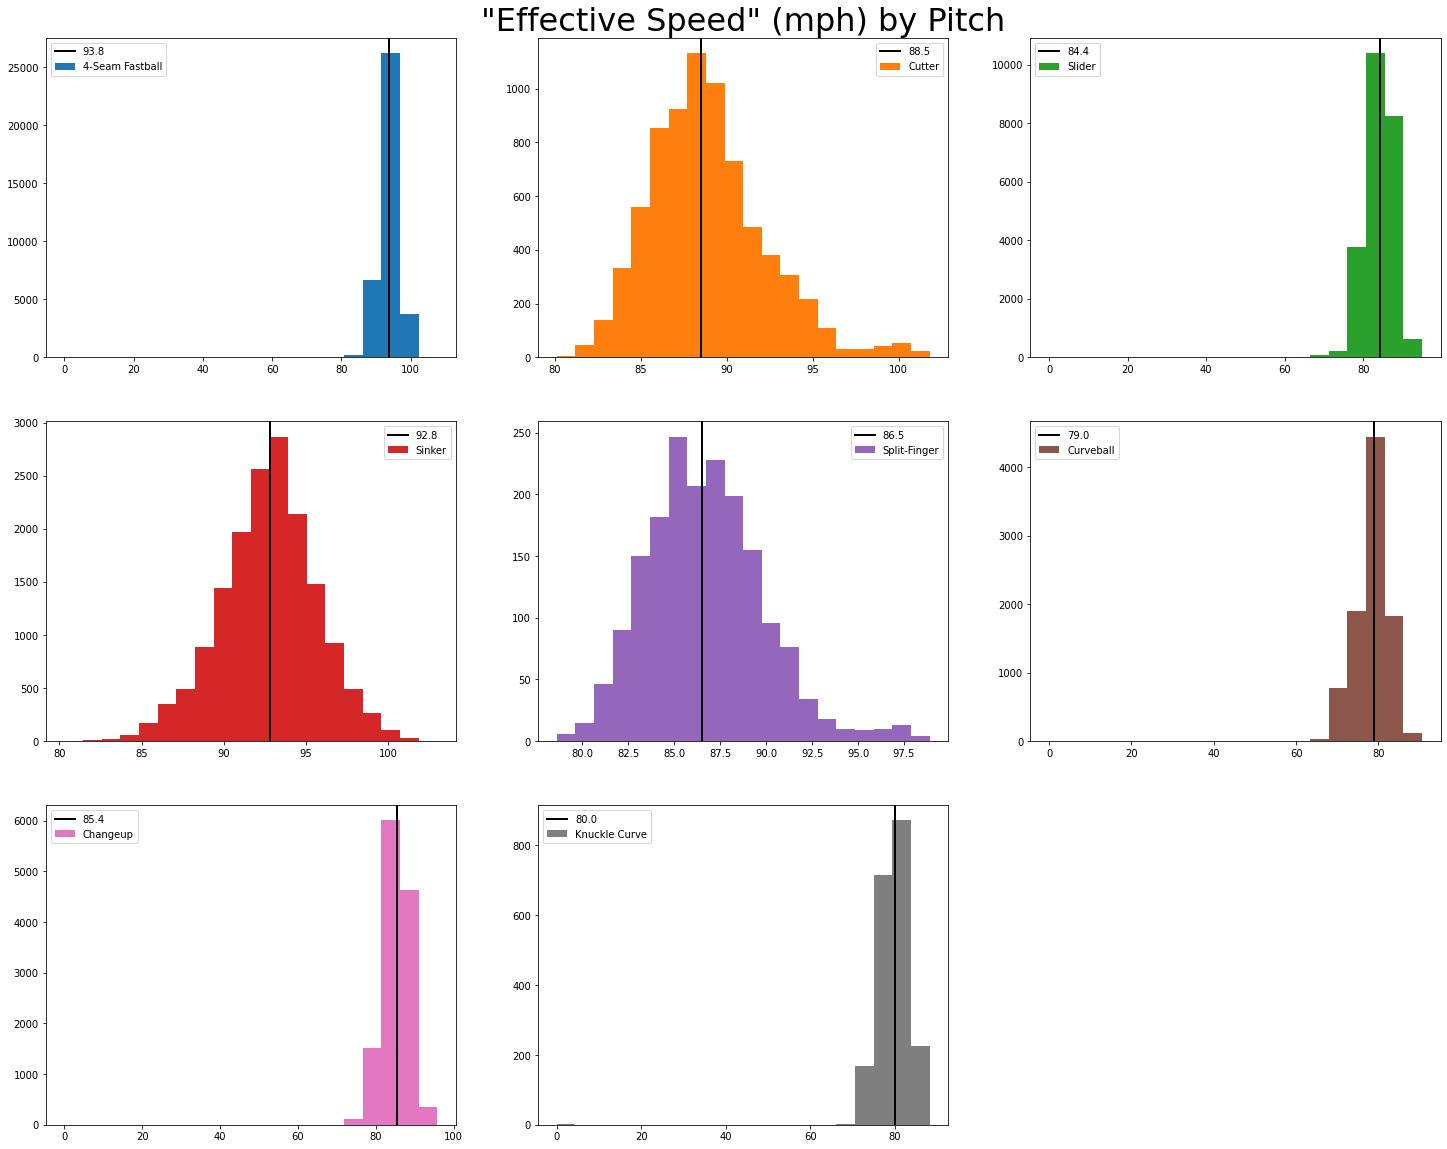

In [ ]:
# Generate a pyplot figure
fig = plt.figure(figsize = (25,20))

# Set title
plt.title('"Effective Speed" (mph) by Pitch', fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each unique pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For effective speed (release speed & extension), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  # Iterate to next color in rotation
  c = next(colors)["color"]

  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.effective_speed[df.pitch_name==val]
  
  ax = fig.add_subplot(3, 3, i+1)
  ax.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax.legend()

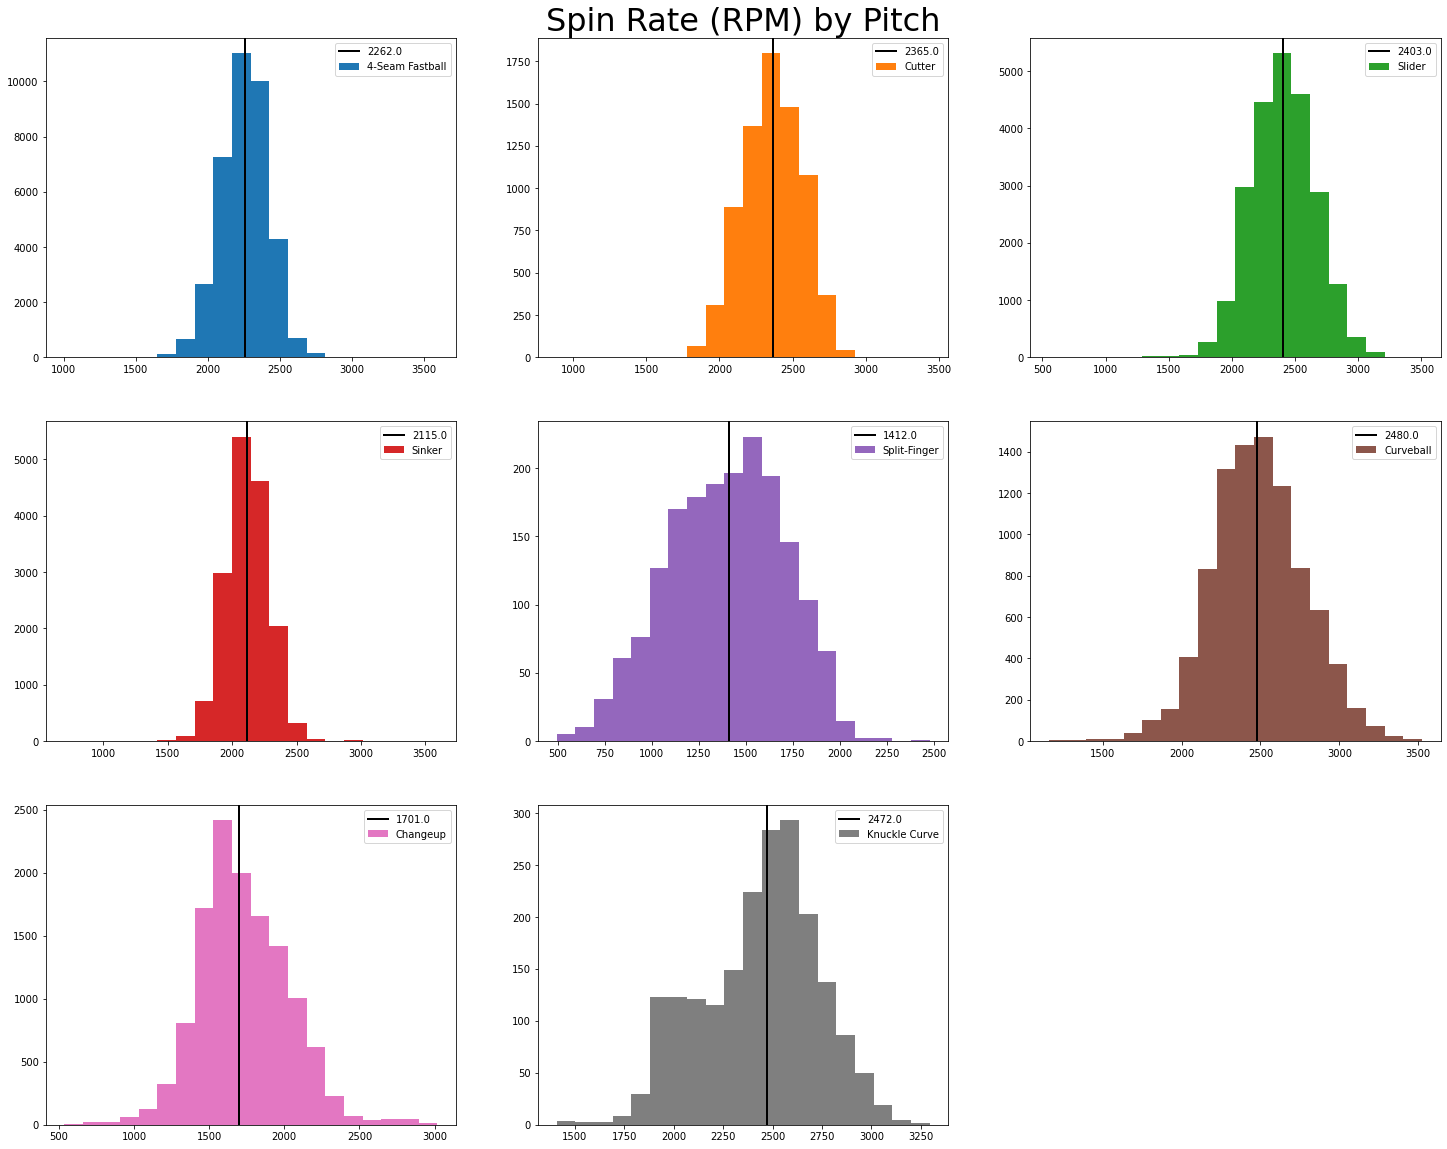

In [ ]:
# Generate a pyplot figure
fig2 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Rate (RPM) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.release_spin_rate[df.pitch_name==val]
  ax2 = fig2.add_subplot(3, 3, i+1)
  ax2.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax2.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax2.legend()

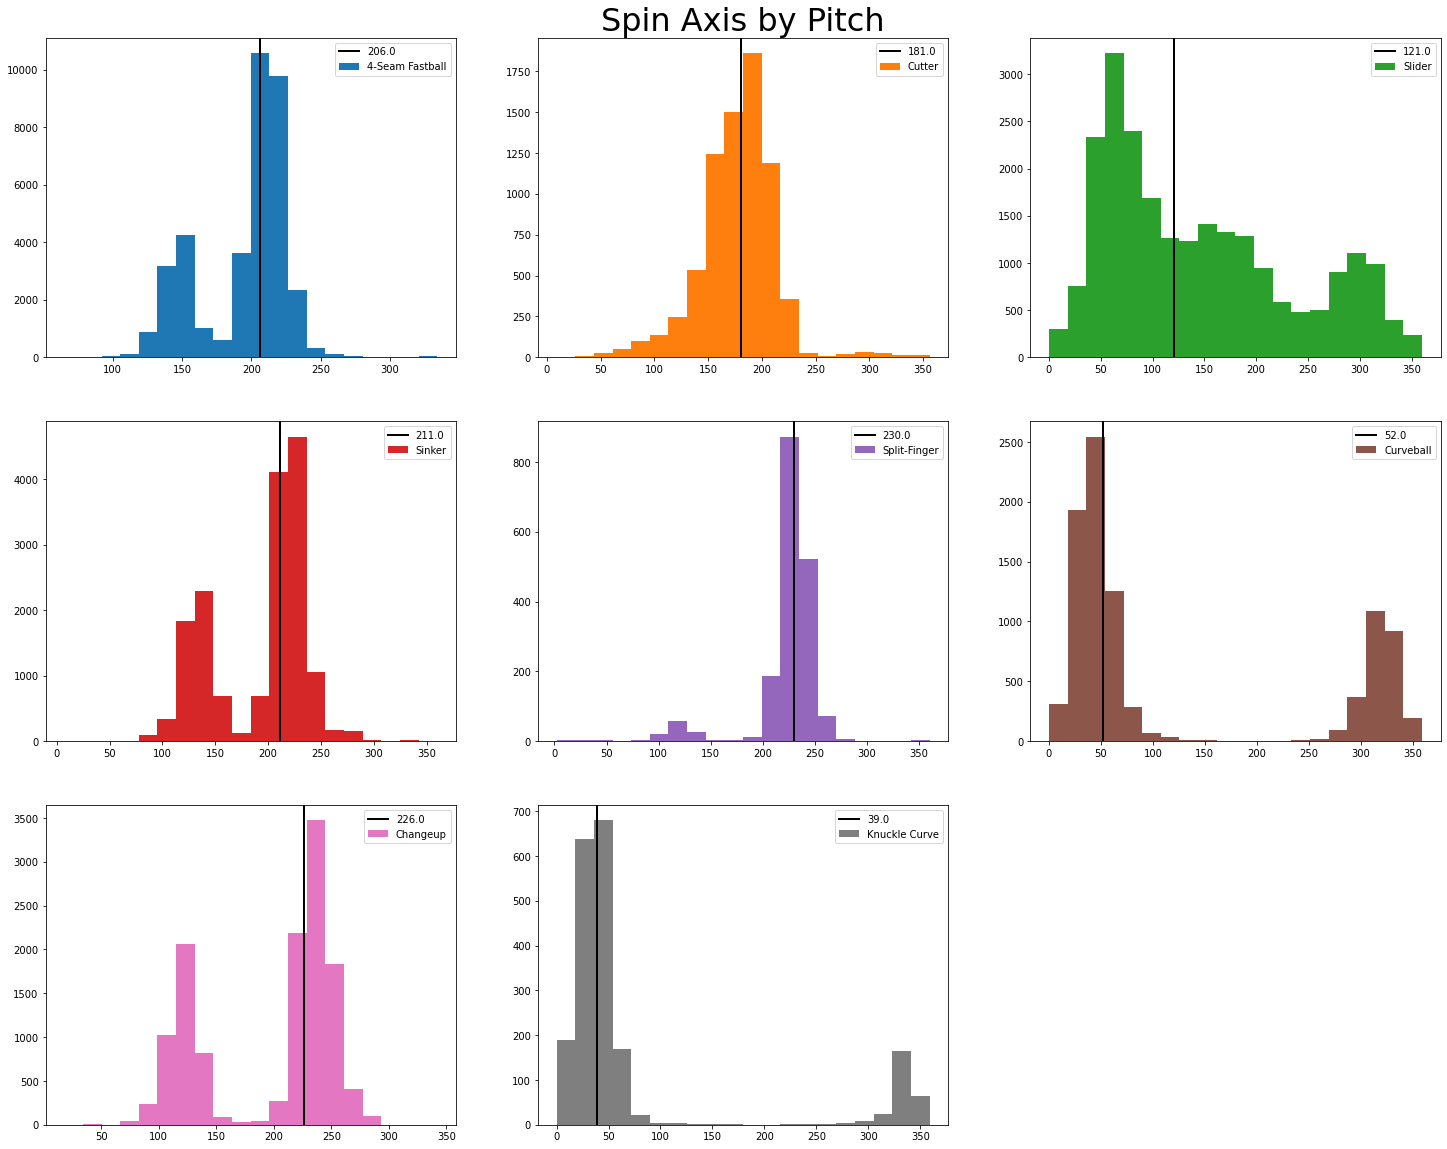

In [ ]:
# Generate a pyplot figure
fig3 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Axis by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.spin_axis[df.pitch_name==val]
  ax3 = fig3.add_subplot(3, 3, i+1)
  ax3.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax3.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax3.legend()

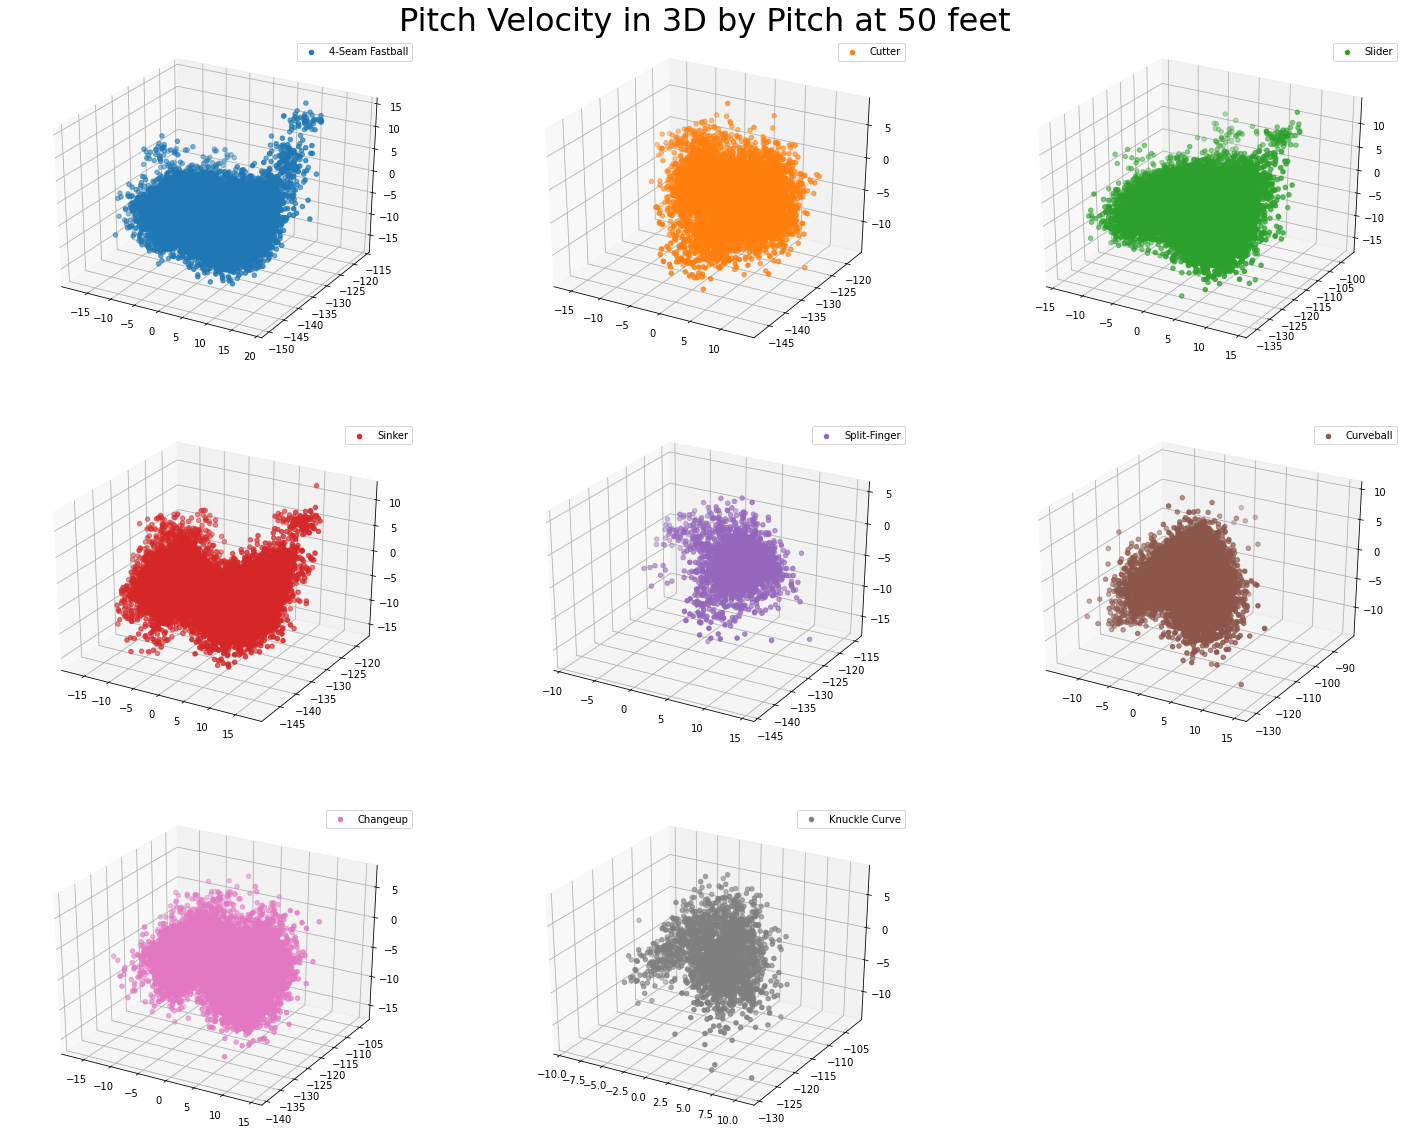

In [ ]:
# 3D Scatterplot of Pitch Velocity at x=y=z=50 feet
fig_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Velocity in 3D by Pitch at 50 feet", fontsize = 32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For velocity in R^3 at 50 feet, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add 3D subplot to visualize 3D data
  ax_3D = fig_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')
  
  ax_3D.scatter(x,y,z,label=val, color = c)
  ax_3D.legend()

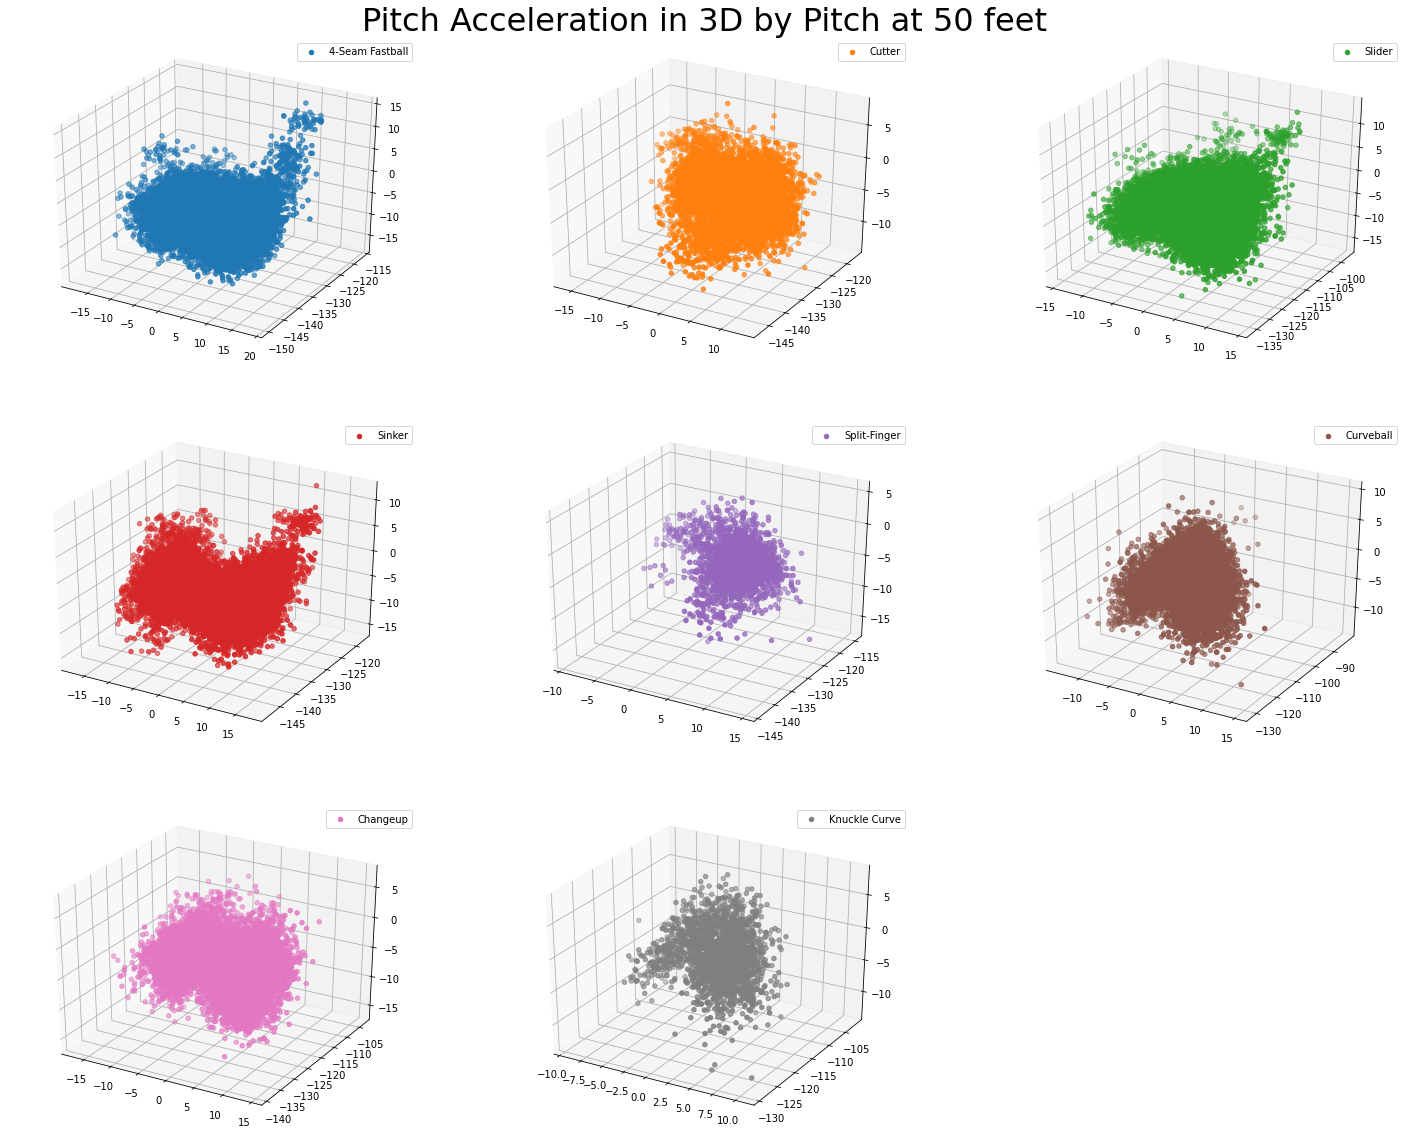

In [ ]:
# 3D Scatterplot of Pitch acceleration in x,y,z dimensions at 50 feet
fig2_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Acceleration in 3D by Pitch at 50 feet", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add a 3D subplot to visualize 3D data
  ax2_3D = fig2_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')

  ax2_3D.scatter(x,y,z,label=val, color = c)
  ax2_3D.legend()

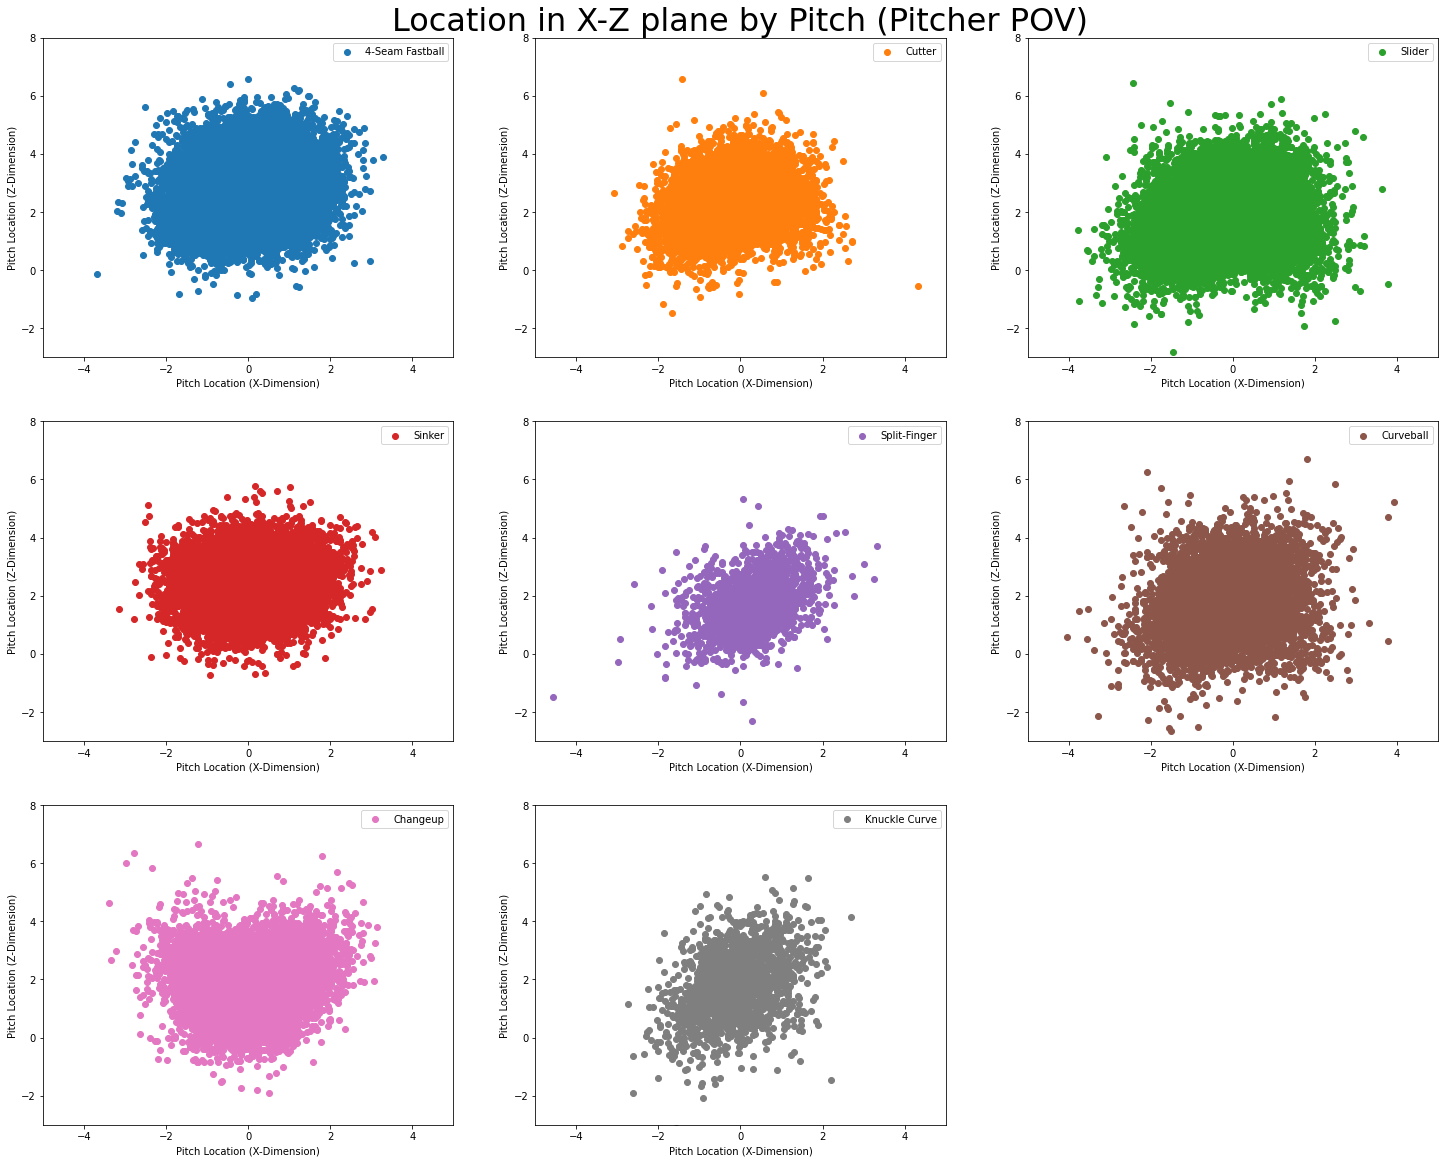

In [ ]:
# Plate location plots
fig4 = plt.figure(figsize = (25,20))
plt.title("Location in X-Z plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax4 = fig4.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the pitch's location in the x-axis to get a pitcher's perspective
  x = df.plate_x[df.pitch_name==val] * -1
  y = df.plate_z[df.pitch_name==val]
  
  ax4.scatter(x=x, y=y,label=val, color = c)
  
  ax4.set_xlim(-5, 5)
  ax4.set_ylim(-3, 8)
  ax4.set_xlabel("Pitch Location (X-Dimension)")
  ax4.set_ylabel("Pitch Location (Z-Dimension)")
  ax4.legend()

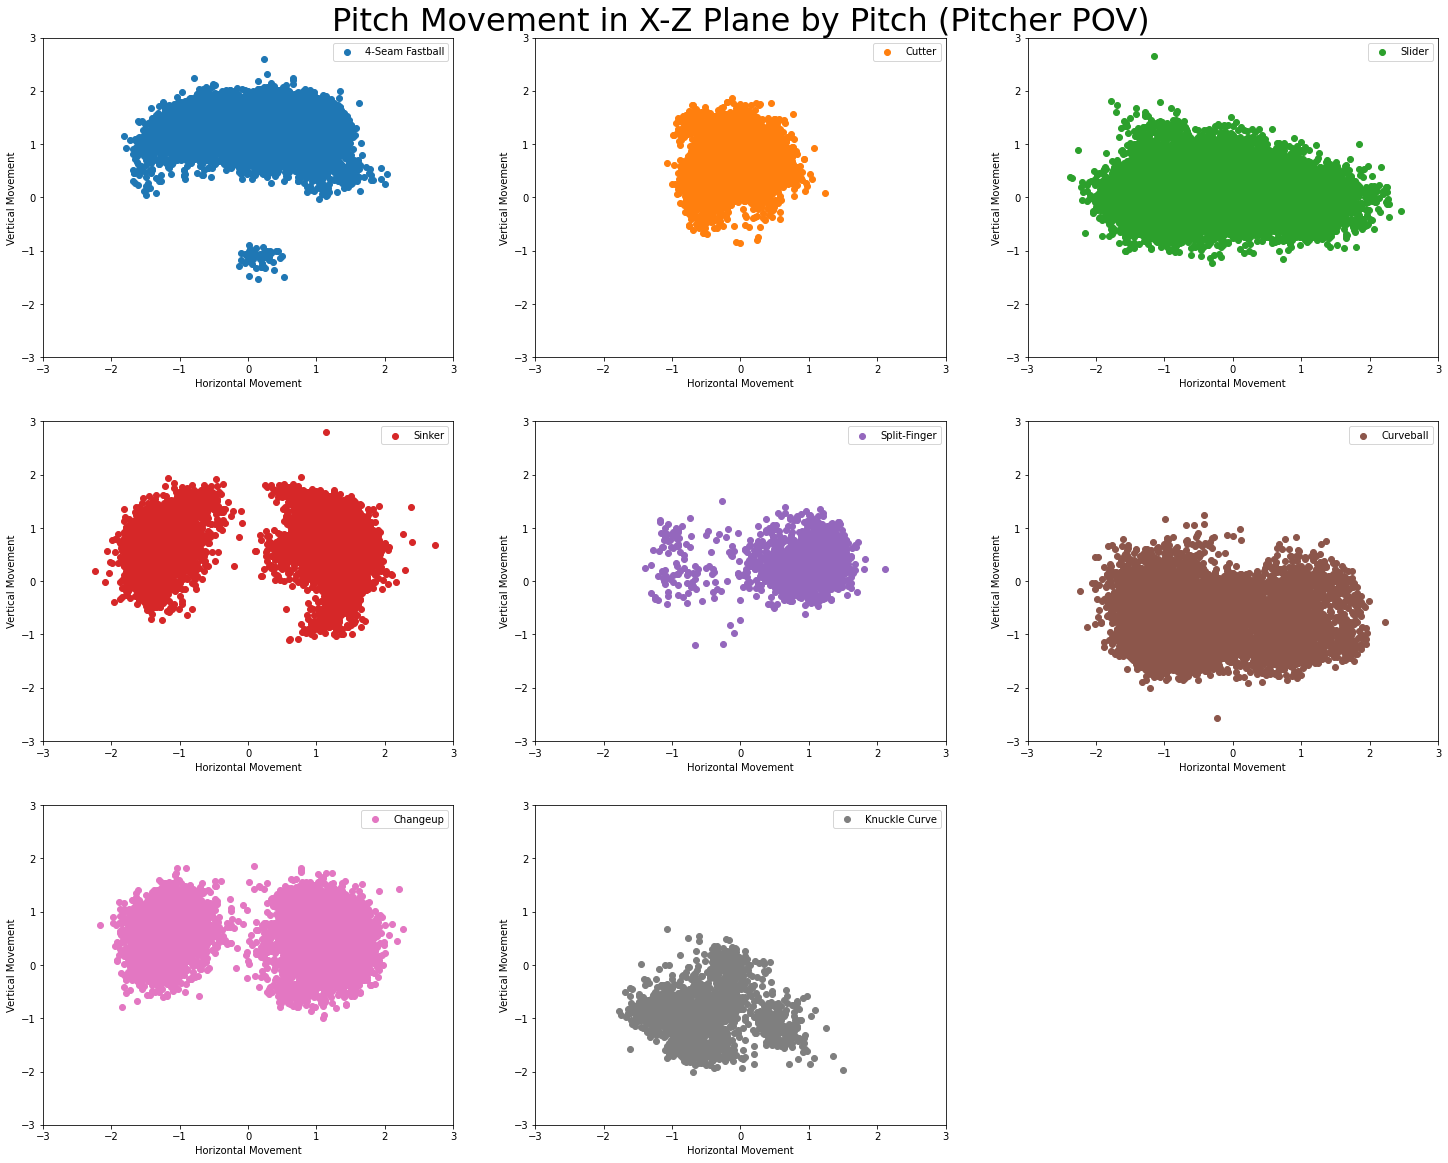

In [ ]:
# Pitch movement scatterplots
fig5 = plt.figure(figsize = (25,20))
plt.title("Pitch Movement in X-Z Plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax5 = fig5.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the movement in the x-axis to get a pitcher's perspective
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val]
  ax5.scatter(x = x,y = y,label=val, color = c)
  
  ax5.set_xlim(-3, 3)
  ax5.set_ylim(-3, 3)
  ax5.set_xlabel("Horizontal Movement")
  ax5.set_ylabel("Vertical Movement")
  ax5.legend()

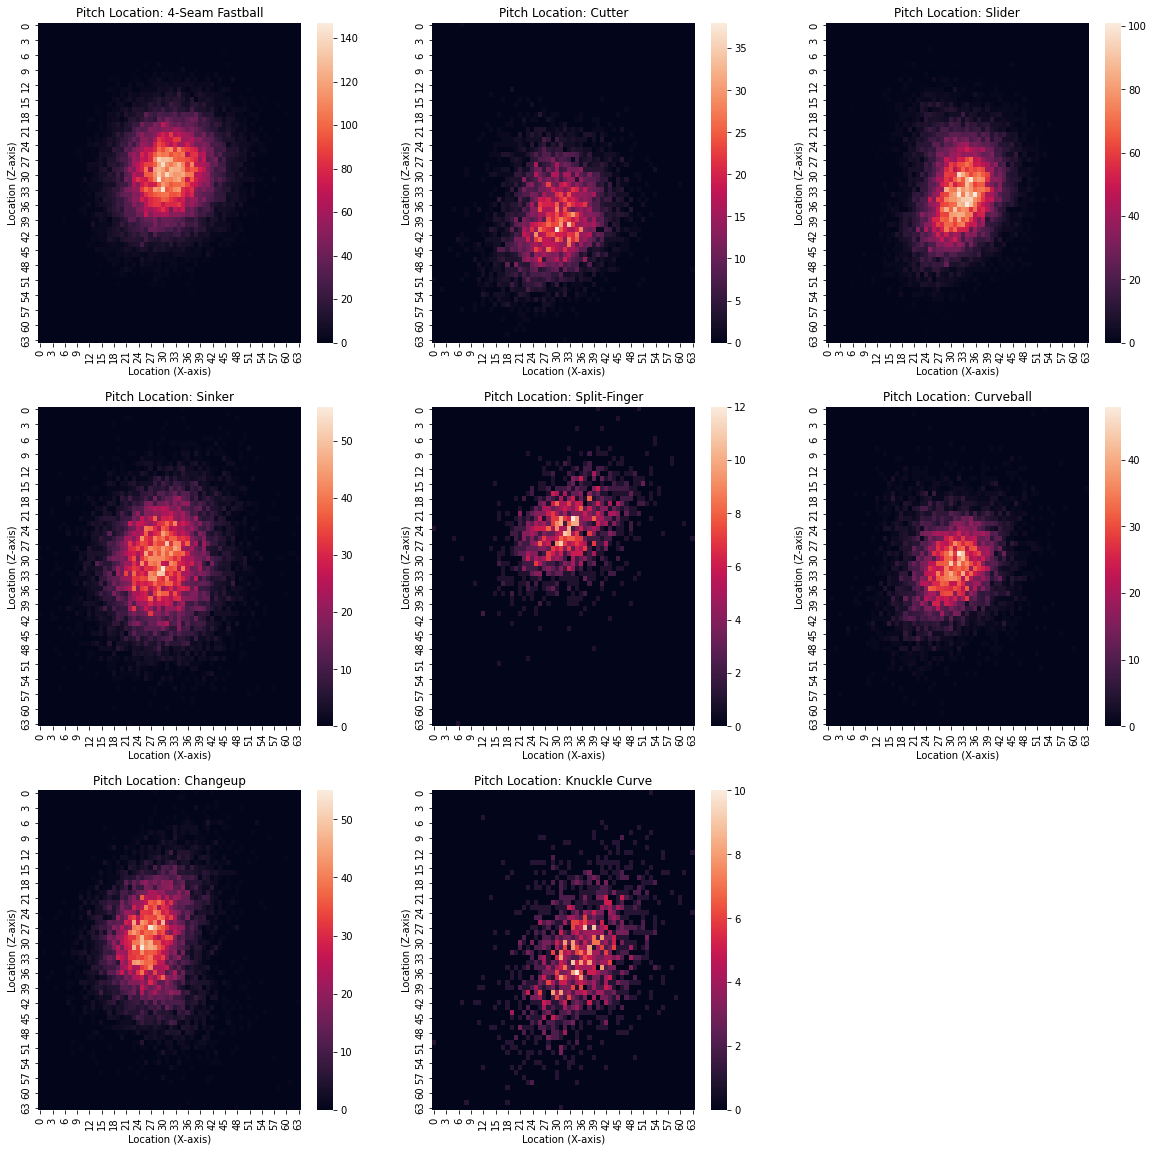

In [ ]:
fig6 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax6 = fig6.add_subplot(3, 3, i+1)

  # Generate location data, convert into 2D array as a heatmap
  x = df.plate_x[df.pitch_name==val]
  y = df.plate_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot as heatmap
  sns.heatmap(heatmap)
  ax6.set(title = f"Pitch Location: {val}",
          xlabel = 'Location (X-axis)',
          ylabel = 'Location (Z-axis)')

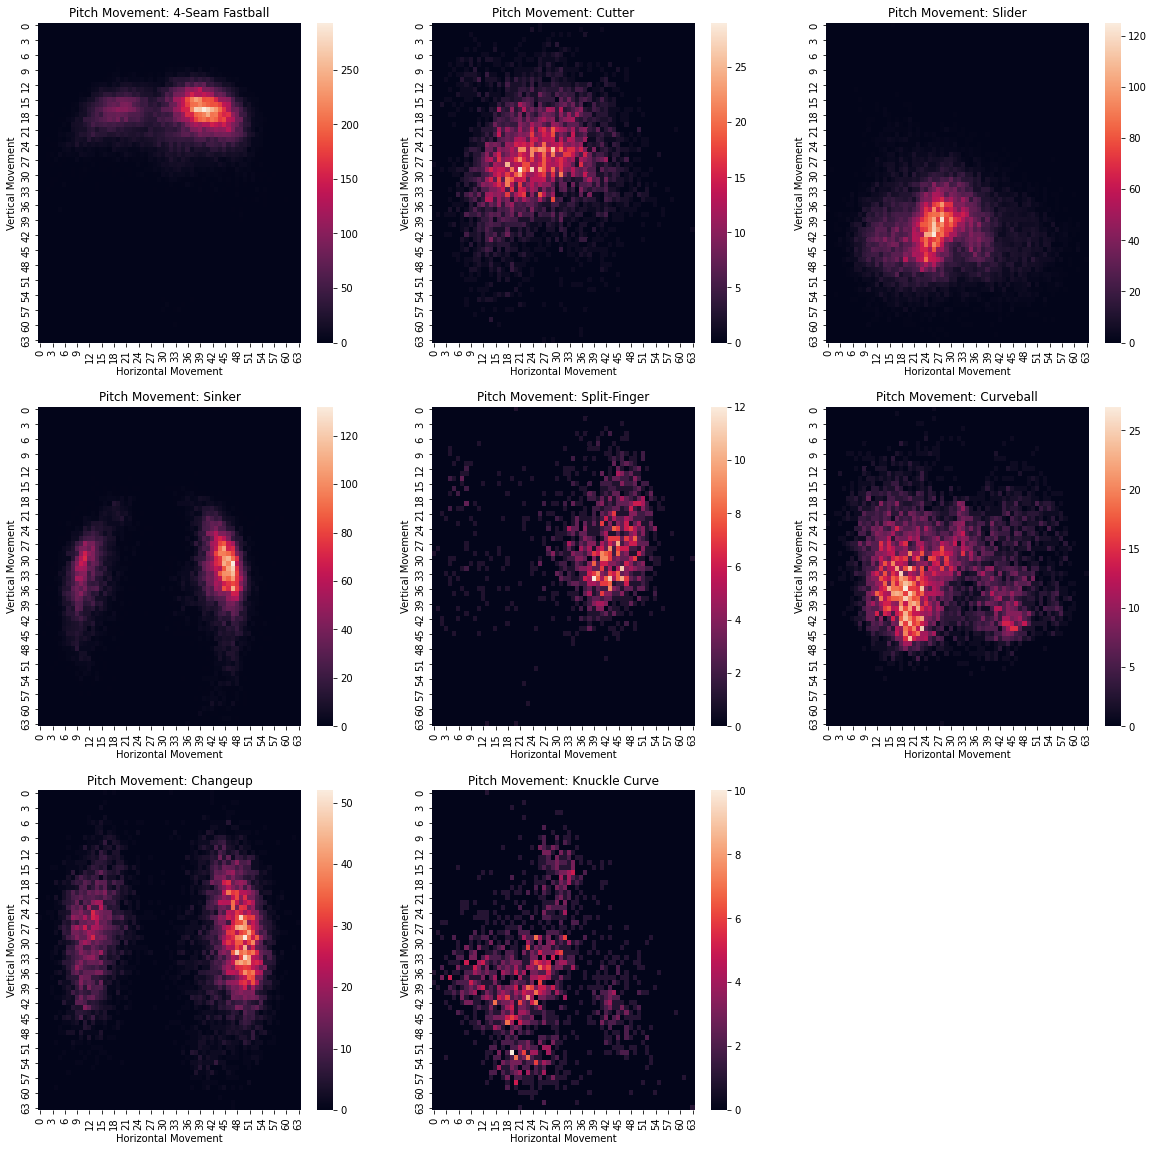

In [ ]:
fig7 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax7 = fig7.add_subplot(3, 3, i+1)

  # Generate 3D data, convert to NumPy 2D Array
  # Flipped to match 2D Scatterplot for Movement
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val] * -1

  heatmap, xedges, yedges = np.histogram2d(y, x, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot
  sns.heatmap(heatmap)
  ax7.set(title = f"Pitch Movement: {val}",
          xlabel = 'Horizontal Movement',
          ylabel = 'Vertical Movement')



## Preprocessing

### Encoding Categorical Columns

In [24]:
X = df.drop(['pitcher',	'player_name', 'pitch_name'], axis=1)
y = df['pitch_name']

In [25]:
label_encoder = LabelEncoder()    

X['p_throws'] = label_encoder.fit_transform(X['p_throws'])
X

,p_throws,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,2325,94.0,93.6,224,5.382151,-136.775257,-2.839128,-14.619862,30.990298,-16.520727,-1.07,1.21,-0.81,3.21
1,1,2276,94.3,94.3,220,6.715543,-137.171502,-2.127793,-13.130822,29.478366,-17.632407,-0.92,1.13,-0.36,3.42
2,1,2280,88.5,88.7,173,4.254826,-128.940834,-1.576828,0.904268,23.752019,-27.383568,0.15,0.42,-0.62,2.61
3,1,2212,85.7,85.8,90,8.364339,-124.70309,-3.906876,2.403307,22.602046,-32.833059,0.37,-0.11,1.53,1.07
4,1,2189,95.2,95.2,223,9.779875,-138.322911,-4.289147,-13.532003,30.522499,-15.31698,-0.89,1.25,1.07,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109559,1,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
109560,1,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
109561,1,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
109562,1,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


In [26]:
X.dtypes

p_throws               int64
release_spin_rate      Int64
release_speed        Float64
effective_speed      Float64
spin_axis              Int64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
pfx_x                Float64
pfx_z                Float64
plate_x              Float64
plate_z              Float64
dtype: object

In [27]:
y

0         4-Seam Fastball
1         4-Seam Fastball
2                  Cutter
3                  Slider
4         4-Seam Fastball
               ...       
109559       Split-Finger
109560             Slider
109561    4-Seam Fastball
109562    4-Seam Fastball
109563    4-Seam Fastball
Name: pitch_name, Length: 109564, dtype: object

In [28]:
label_encoder2 = LabelEncoder()

y = label_encoder2.fit_transform(y)
y

array([0, 0, 3, ..., 0, 0, 0])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=0,
                                                    stratify = y) 

In [30]:
# Stratified sampling
def to_freq_dict(counter):
  ret_di = {}

  counter_total = sum(i[1] for i in counter)
  
  for i in counter:
    ret_di[i[0]] = round((i[1] / counter_total) * 100 , 1)

  return ret_di

pitch_freq = to_freq_dict(sorted(Counter(y).items(), key=itemgetter(0)))
y_train_freq = to_freq_dict(sorted(Counter(y_train).items(), key=itemgetter(0)))
y_test_freq = to_freq_dict(sorted(Counter(y_test).items(), key=itemgetter(0)))

print(pitch_freq)
print(y_train_freq)
print(y_test_freq)

{0: 33.8, 1: 11.5, 2: 8.3, 3: 6.8, 4: 1.8, 5: 14.8, 6: 21.3, 7: 1.6}
{0: 33.8, 1: 11.5, 2: 8.3, 3: 6.8, 4: 1.8, 5: 14.8, 6: 21.3, 7: 1.6}
{0: 33.8, 1: 11.5, 2: 8.3, 3: 6.8, 4: 1.8, 5: 14.8, 6: 21.3, 7: 1.6}


In [31]:
pitch_df = pd.DataFrame()
pitch_df['label'] = df['pitch_name']
pitch_df['encoded'] = y.tolist()
pitch_encoded = round( pitch_df.value_counts(sort=False, ascending=False) / len(df) * 100, 1)#/

pitch_encoded

label            encoded
4-Seam Fastball  0          33.8
Changeup         1          11.5
Curveball        2           8.3
Cutter           3           6.8
Knuckle Curve    4           1.8
Sinker           5          14.8
Slider           6          21.3
Split-Finger     7           1.6
dtype: float64

### Standardization

In [32]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

## Model Construction

### Random Forest Classifier

In [33]:
# Default Estimators = 100, criterion = 'gini'
rfc = RandomForestClassifier()

In [34]:
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [35]:
conf_matrix_rfc = confusion_matrix(y_pred_rfc, y_test)
conf_matrix_rfc

array([[7167,    4,    0,  112,    0,  281,   15,    0],
       [   8, 2385,    0,    1,    0,   56,    8,  167],
       [   0,    2, 1467,    5,  155,    0,  134,    0],
       [  61,    1,    1,  993,    0,    3,  236,    0],
       [   0,    0,   26,    0,  202,    0,    7,    0],
       [ 157,   81,    0,    3,    0, 2911,    0,    5],
       [   2,    9,  331,  369,   39,    0, 4274,    2],
       [   1,   45,    0,    1,    0,    0,    1,  185]])

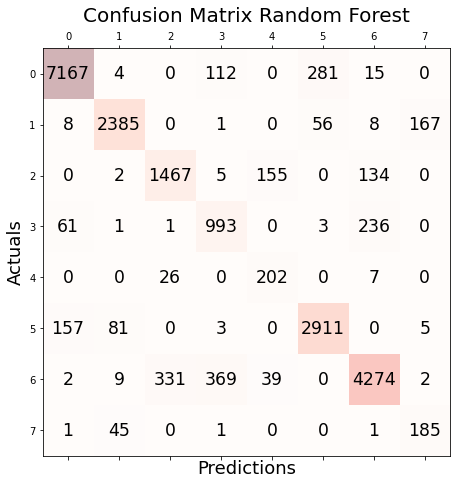

In [36]:
fig_rfc , ax_rfc = plt.subplots(figsize=(7.5, 7.5))
ax_rfc.matshow(conf_matrix_rfc, cmap=plt.cm.Reds, alpha=0.3)

for i in range(conf_matrix_rfc.shape[0]):
    for j in range(conf_matrix_rfc.shape[1]):
        ax_rfc.text(x=j, y=i,s=conf_matrix_rfc[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Random Forest', fontsize=20)
plt.show()

In [37]:
rows_rfc = conf_matrix_rfc.sum(axis = 1, keepdims = True)
normalized_matrix_rfc = conf_matrix_rfc / rows_rfc

np.fill_diagonal(normalized_matrix_rfc, 0)
normalized_matrix_rfc = np.round_(normalized_matrix_rfc, 4)
normalized_matrix_rfc

array([[0.    , 0.0005, 0.    , 0.0148, 0.    , 0.0371, 0.002 , 0.    ],
       [0.003 , 0.    , 0.    , 0.0004, 0.    , 0.0213, 0.003 , 0.0636],
       [0.    , 0.0011, 0.    , 0.0028, 0.0879, 0.    , 0.076 , 0.    ],
       [0.0471, 0.0008, 0.0008, 0.    , 0.    , 0.0023, 0.1822, 0.    ],
       [0.    , 0.    , 0.1106, 0.    , 0.    , 0.    , 0.0298, 0.    ],
       [0.0497, 0.0257, 0.    , 0.001 , 0.    , 0.    , 0.    , 0.0016],
       [0.0004, 0.0018, 0.0659, 0.0734, 0.0078, 0.    , 0.    , 0.0004],
       [0.0043, 0.1931, 0.    , 0.0043, 0.    , 0.    , 0.0043, 0.    ]])

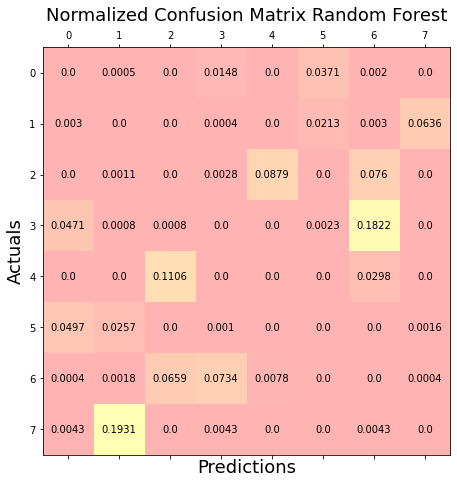

In [38]:
fig_rfc2, ax_rfc2 = plt.subplots(figsize=(7.5, 7.5))
ax_rfc2.matshow(normalized_matrix_rfc, cmap=plt.cm.autumn, alpha=0.3)

for i in range(normalized_matrix_rfc.shape[0]):
  for j in range(normalized_matrix_rfc.shape[1]):
    ax_rfc2.text(x=j, y=i,s=normalized_matrix_rfc[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix Random Forest', fontsize=18)
plt.show()

In [39]:
print("Random Forest Classifier Testing set accuracy: ", rfc.score(X_test, y_test))
print("Random Forest Classifier Training set accuracy: ", rfc.score(X_train, y_train))

Random Forest Classifier Testing set accuracy:  0.8937160589604345
Random Forest Classifier Training set accuracy:  0.9999885911170437


In [40]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7396
           1       0.91      0.94      0.93      2527
           2       0.83      0.80      0.82      1825
           3       0.77      0.67      0.71      1484
           4       0.86      0.51      0.64       396
           5       0.92      0.90      0.91      3251
           6       0.85      0.91      0.88      4675
           7       0.79      0.52      0.62       359

    accuracy                           0.89     21913
   macro avg       0.86      0.78      0.81     21913
weighted avg       0.89      0.89      0.89     21913



In [41]:
y_cv_pred_rfc = cross_val_predict(rfc, X_train, y_train, cv=5)
f1_score(y_train, y_cv_pred_rfc, average="macro")

0.7895021707211148

#### Random Forest Classifier ROC

In [42]:
# ROC: plotted true positive rate against false positive rate
# Multiclass classification can be One vs. One (combinations of two classes), 
#    or One vs. Rest (one class classified against all others put together)
y_proba = rfc.predict_proba(X_test)

# Binarize output, transformed to a sample containing all 8 pitch classes
label_binarizer = LabelBinarizer().fit(y_train)
y_OvR_test = label_binarizer.transform(y_test)
y_OvR_test.shape  # (n_samples, n_classes)

(21913, 8)

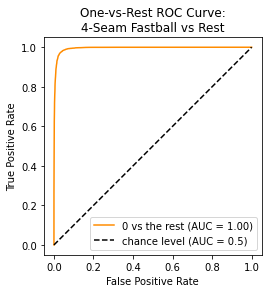

In [43]:
# Example ROC: 4-Seam Fastballs
four_seam_class = 0 # 4-Seam Class ID = 0
class_id = np.flatnonzero(label_binarizer.classes_ == four_seam_class)[0]
class_id

# plot False Positive Rate (X) and True Positive rate (Y) of 4-Seam Fastballs
# Ideal spot is in top left corner, where the false positive rate is lowest and
# true positive rate is highest
RocCurveDisplay.from_predictions(
    y_OvR_test[:, class_id],
    y_proba[:, class_id],
    name=f"{four_seam_class} vs the rest",
    color="darkorange",
)
# Add y=x line
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curve:\n4-Seam Fastball vs Rest")
plt.legend()
plt.show()

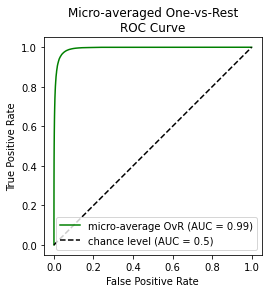

In [44]:
# Average ROC Curve of all pitch classes ROC curves against other pitch classes,
# averaged out into one line
RocCurveDisplay.from_predictions(
    y_OvR_test.ravel(),
    y_proba.ravel(),
    name="micro-average OvR",
    color="green",
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nROC Curve")
plt.legend()
plt.show()

In [45]:
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_OvR_test.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Micro-averaged ROC AUC score for all pitch class in One vs. Rest classification with other classes
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99


In [46]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_OvR_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


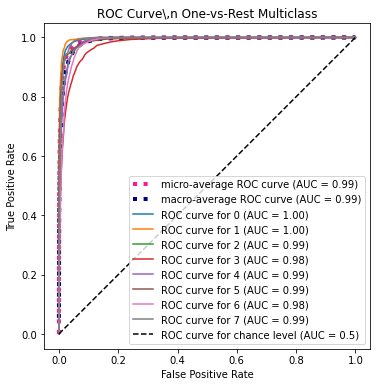

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = plt.rcParams["axes.prop_cycle"]()


for class_id in range(n_classes):
    c = next(colors)["color"]
    
    RocCurveDisplay.from_predictions(
        y_OvR_test[:, class_id],
        y_proba[:, class_id],
        name=f"ROC curve for {class_id}",
        color=c,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve\,n One-vs-Rest Multiclass")
plt.legend()
plt.show()

#### Fine-Tuning

In [68]:
rfc_params = { 
    'n_estimators': [10, 20, 50, 100],
    'max_depth' : [int(x) for x in range(10, 60, 10)],
    'min_samples_split': [2, 6, 10],
    'criterion' : ['gini', 'entropy']
}

In [69]:
rfc_cv = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_params, cv= 5)
rfc_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [10, 20, 50, 100]})

In [70]:
print('Best Parameters: ', rfc_cv.best_params_, '\n')
print('Best Score: ', rfc_cv.best_score_, '\n')

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 36, 'criterion': 'gini'} 

Best Score:  0.8850897285919365 



In [71]:
rfc2 = RandomForestClassifier(n_estimators= 50, min_samples_split=2, max_depth=36, criterion = 'gini')
rfc2.fit(X_train, y_train)

RandomForestClassifier(max_depth=36, n_estimators=50)

In [72]:
y_pred_rfc2 = rfc2.predict(X_test)

In [73]:
conf_matrix_rfc2 = confusion_matrix(y_pred_rfc2, y_test)
conf_matrix_rfc2

array([[7171,    4,    0,  125,    0,  277,   14,    0],
       [   6, 2390,    0,    1,    0,   68,    5,  170],
       [   0,    2, 1476,    4,  165,    0,  146,    0],
       [  55,    1,    2,  967,    0,    6,  232,    0],
       [   0,    0,   24,    0,  193,    0,   11,    0],
       [ 161,   77,    0,    2,    0, 2900,    2,    7],
       [   3,    7,  323,  384,   38,    0, 4264,    3],
       [   0,   46,    0,    1,    0,    0,    1,  179]])

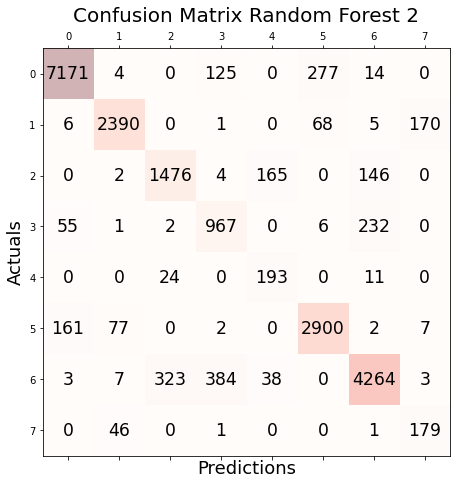

In [74]:
fig_rfc3 , ax_rfc3 = plt.subplots(figsize=(7.5, 7.5))
ax_rfc3.matshow(conf_matrix_rfc2, cmap=plt.cm.Reds, alpha=0.3)

for i in range(conf_matrix_rfc2.shape[0]):
    for j in range(conf_matrix_rfc2.shape[1]):
        ax_rfc3.text(x=j, y=i,s=conf_matrix_rfc2[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Random Forest (Fine-Tuned)', fontsize=20)
plt.show()

In [75]:
rows_rfc2 = conf_matrix_rfc2.sum(axis = 1, keepdims = True)
normalized_matrix_rfc2 = conf_matrix_rfc2 / rows_rfc2

np.fill_diagonal(normalized_matrix_rfc2, 0)
normalized_matrix_rfc2 = np.round_(normalized_matrix_rfc2, 4)
normalized_matrix_rfc2

array([[0.    , 0.0005, 0.    , 0.0165, 0.    , 0.0365, 0.0018, 0.    ],
       [0.0023, 0.    , 0.    , 0.0004, 0.    , 0.0258, 0.0019, 0.0644],
       [0.    , 0.0011, 0.    , 0.0022, 0.092 , 0.    , 0.0814, 0.    ],
       [0.0435, 0.0008, 0.0016, 0.    , 0.    , 0.0048, 0.1837, 0.    ],
       [0.    , 0.    , 0.1053, 0.    , 0.    , 0.    , 0.0482, 0.    ],
       [0.0511, 0.0245, 0.    , 0.0006, 0.    , 0.    , 0.0006, 0.0022],
       [0.0006, 0.0014, 0.0643, 0.0765, 0.0076, 0.    , 0.    , 0.0006],
       [0.    , 0.2026, 0.    , 0.0044, 0.    , 0.    , 0.0044, 0.    ]])

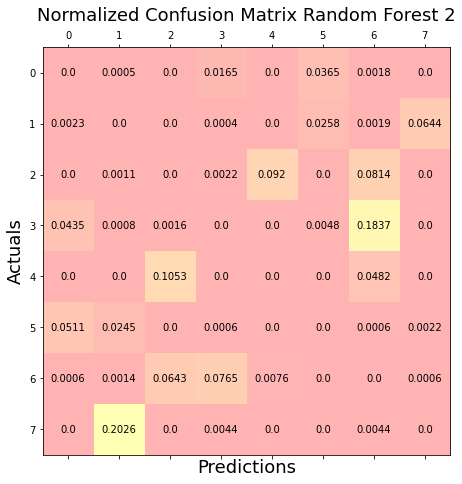

In [76]:
fig_rfc4, ax_rfc4 = plt.subplots(figsize=(7.5, 7.5))
ax_rfc4.matshow(normalized_matrix_rfc2, cmap=plt.cm.autumn, alpha=0.3)

for i in range(normalized_matrix_rfc2.shape[0]):
  for j in range(normalized_matrix_rfc2.shape[1]):
    ax_rfc4.text(x=j, y=i,s=normalized_matrix_rfc2[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix Random Forest (Fine-Tuned)', fontsize=18)
plt.show()

In [77]:
print("Random Forest Classifier Testing set accuracy: ", rfc2.score(X_test, y_test))
print("Random Forest Classifier Training set accuracy: ", rfc2.score(X_train, y_train))

Random Forest Classifier Testing set accuracy:  0.8917081184684891
Random Forest Classifier Training set accuracy:  0.999874502287481


In [78]:
print(classification_report(y_test, y_pred_rfc2))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7396
           1       0.91      0.95      0.93      2527
           2       0.82      0.81      0.82      1825
           3       0.77      0.65      0.70      1484
           4       0.85      0.49      0.62       396
           5       0.92      0.89      0.91      3251
           6       0.85      0.91      0.88      4675
           7       0.79      0.50      0.61       359

    accuracy                           0.89     21913
   macro avg       0.86      0.77      0.80     21913
weighted avg       0.89      0.89      0.89     21913



In [79]:
y_cv_pred_rfc2 = cross_val_predict(rfc2, X_train, y_train, cv=5)
f1_score(y_train, y_cv_pred_rfc2, average="macro")

0.7875205678114419